In [1]:
# Import package
import numpy as np
import pandas as pd 
import nltk
import re
import string
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
raw_articles_data = pd.read_excel('/content/gdrive/MyDrive/data/news_dataset.xlsx')

In [4]:
raw_articles_data

,Unnamed: 0,source,author,title,description,url,urlToImage,publishedAt,content
0,0,"{'id': 'the-verge', 'name': 'The Verge'}",Jon Porter,Twitter’s voice DMs arrive in India,Twitter has rolled out support for voice DMs o...,https://www.theverge.com/2021/2/17/22287091/tw...,https://cdn.vox-cdn.com/thumbor/31wcDz-dd7XKS5...,2021-02-17T13:18:32Z,For when theres just way too much to type\r\nI...
1,1,"{'id': 'engadget', 'name': 'Engadget'}",Daniel Cooper,Amazon follows Netflix with mobile-only video ...,"Amazon Prime Video and Bharti Airtel, India’s ...",https://www.engadget.com/amazon-prime-video-mo...,https://o.aolcdn.com/images/dims?resize=1200%2...,2021-01-13T11:15:31Z,"Amazon Prime Video and Bharti Airtel, India’s ..."
2,2,"{'id': 'techcrunch', 'name': 'TechCrunch'}",Manish Singh,India bans PUBG and over 100 additional Chines...,India has banned more than 100 additional Chin...,http://techcrunch.com/2020/09/02/india-bans-pu...,https://techcrunch.com/wp-content/uploads/2020...,2020-09-02T12:02:29Z,India has banned more than 100 additional apps...
3,3,"{'id': 'engadget', 'name': 'Engadget'}",Steve Dent,Samsung begins offering support requests via W...,With the COVID-19 crisis continuing unabated i...,https://www.engadget.com/samsung-whatsapp-smar...,https://o.aolcdn.com/images/dims?resize=1200%2...,2020-07-06T08:49:00Z,With the COVID-19 crisis continuing unabated i...
4,4,"{'id': 'engadget', 'name': 'Engadget'}",Mariella Moon,Sony is launching the PS5 in India on February...,PlayStation gamers in India will finally have ...,https://www.engadget.com/sony-ps5-india-launch...,https://o.aolcdn.com/images/dims?resize=1200%2...,2021-01-01T09:05:35Z,PlayStation gamers in India will finally have ...
...,...,...,...,...,...,...,...,...,...
9895,9895,"{'id': None, 'name': 'New York Times'}",Allyson Waller,A Cat Is Said to Be Joining the Bidens in the ...,"The last cat to live in the White House, India...",https://www.nytimes.com/2020/11/28/us/Biden-ca...,https://static01.nyt.com/images/2020/11/28/mul...,2020-11-29T00:35:41Z,"Jennifer Pickens, a White House historian and ..."
9896,9896,"{'id': 'reuters', 'name': 'Reuters'}",NaN,India this week - Reuters India,A policeman directs crowd at a railway station...,https://in.reuters.com/news/picture/india-this...,https://s4.reutersmedia.net/resources/r/?m=02&...,2020-12-04T17:42:09Z,"Reuters, the news and media division of Thomso..."
9897,9897,"{'id': None, 'name': 'BBC News'}",https://www.facebook.com/bbcnews,India extends coronavirus lockdown by two weeks,The country's major cities will remain under s...,https://www.bbc.com/news/world-asia-india-5269...,https://ichef.bbci.co.uk/news/1024/branded_new...,2020-05-17T14:48:13Z,Image copyrightGetty ImagesImage caption\r\n T...
9898,9898,"{'id': 'bbc-news', 'name': 'BBC News'}",https://www.facebook.com/bbcnews,India coronavirus: Bihar braces for 'corona st...,Cases are rising fast in one of India's poores...,https://www.bbc.co.uk/news/world-asia-india-53...,https://ichef.bbci.co.uk/news/1024/branded_new...,2020-07-26T23:11:51Z,Image copyrightGetty ImagesImage caption\r\n B...


In [5]:
titles=[]
dates=[]
descriptions=[]
contents=[]
for index,item in raw_articles_data.iterrows():
  titles.append(item['title'])
  dates.append(item['publishedAt'])
  descriptions.append(item['description'])
  contents.append(item['content'])




In [6]:
dataset=pd.DataFrame({'title': titles, 'date': dates, 'desc': descriptions, 'content': contents})
dataset=dataset.drop_duplicates(subset='title').reset_index(drop=True)
dataset=dataset.dropna()

In [7]:
dataset.head()

,title,date,desc,content
0,Twitter’s voice DMs arrive in India,2021-02-17T13:18:32Z,Twitter has rolled out support for voice DMs o...,For when theres just way too much to type\r\nI...
1,Amazon follows Netflix with mobile-only video ...,2021-01-13T11:15:31Z,"Amazon Prime Video and Bharti Airtel, India’s ...","Amazon Prime Video and Bharti Airtel, India’s ..."
2,India bans PUBG and over 100 additional Chines...,2020-09-02T12:02:29Z,India has banned more than 100 additional Chin...,India has banned more than 100 additional apps...
3,Samsung begins offering support requests via W...,2020-07-06T08:49:00Z,With the COVID-19 crisis continuing unabated i...,With the COVID-19 crisis continuing unabated i...
4,Sony is launching the PS5 in India on February...,2021-01-01T09:05:35Z,PlayStation gamers in India will finally have ...,PlayStation gamers in India will finally have ...


In [8]:
dataset.shape

(100, 4)

In [9]:
# Create function to process and tokenize raw texts
def preprocess(text, stopwords={}, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    # Lower case
    text = text.lower()
    # Handle URL
    text = re.sub(r"https?://t.co/\w{10}",' ', text)
    # Deal with "'s" 
    text = re.sub(r"'s", "", text)
    # Deal with "'" 
    translator2 = str.maketrans({key: None for key in string.punctuation[6]})
    text = text.translate(translator2) 
    # Deal with the rest of punctuations
    translator3 = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator3)
    # Handle unicode
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    # Split the text
    r1 = nltk.word_tokenize(text)
    # Lemmatize the text
    r2 = [lemmatizer.lemmatize(word) for word in r1]
    # Remove the stopwords
    r3 = [word for word in r2 if not word in stopwords]
    # Remove digits
    r4 = [word for word in r3 if word.isalpha()]
    return r4

In [10]:
# Import NLTK stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
extra_stopwords = set()
stopwords = set(nltk.corpus.stopwords.words('english')) | extra_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [11]:
# Put the preprocessed texts into a list
articles = []

for i in range(0,dataset.shape[0]):
    tokenized_text = preprocess(dataset['content'][i], stopwords)
    articles.append(' '.join(tokenized_text))

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
doc = CountVectorizer()
word_count=doc.fit_transform(articles)
word_count.shape
print(word_count)

  (0, 1030)	1
  (0, 622)	1
  (0, 992)	1
  (0, 471)	1
  (0, 29)	1
  (0, 147)	1
  (0, 1013)	1
  (0, 990)	1
  (0, 437)	2
  (0, 816)	1
  (0, 927)	1
  (0, 1024)	1
  (0, 279)	1
  (0, 597)	1
  (0, 508)	1
  (0, 45)	1
  (0, 484)	1
  (0, 898)	1
  (0, 968)	1
  (0, 191)	1
  (0, 157)	1
  (1, 484)	1
  (1, 157)	1
  (1, 39)	1
  (1, 740)	2
  :	:
  (98, 163)	1
  (98, 676)	1
  (98, 427)	1
  (98, 1049)	1
  (99, 437)	1
  (99, 484)	1
  (99, 191)	1
  (99, 157)	1
  (99, 47)	1
  (99, 348)	1
  (99, 1037)	2
  (99, 53)	1
  (99, 726)	1
  (99, 952)	1
  (99, 692)	2
  (99, 117)	1
  (99, 612)	1
  (99, 1015)	1
  (99, 691)	1
  (99, 540)	1
  (99, 317)	1
  (99, 98)	1
  (99, 110)	1
  (99, 1017)	1
  (99, 941)	1


In [21]:
print(word_count.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=doc.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(40)

,idf_weights
char,1.009950
india,1.258412
ha,1.853920
new,2.619388
largest,2.670682
world,2.724749
market,2.781907
country,2.781907
second,2.907070
service,2.976063


In [23]:
tf_idf_vector=tfidf_transformer.transform(word_count)
feature_names = doc.get_feature_names()
first_document_vector=tf_idf_vector[1]
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(45)

,tfidf
mobile,0.491242
video,0.433602
prime,0.369258
carrier,0.201204
teaming,0.201204
variety,0.201204
bharti,0.201204
bolt,0.201204
nu,0.201204
airtel,0.201204


In [24]:
tf_idf_vector

<100x1064 sparse matrix of type '<class 'numpy.float64'>'
	with 2028 stored elements in Compressed Sparse Row format>

In [25]:
print(tf_idf_vector.shape)

(100, 1064)


In [26]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tf_idf_vector)

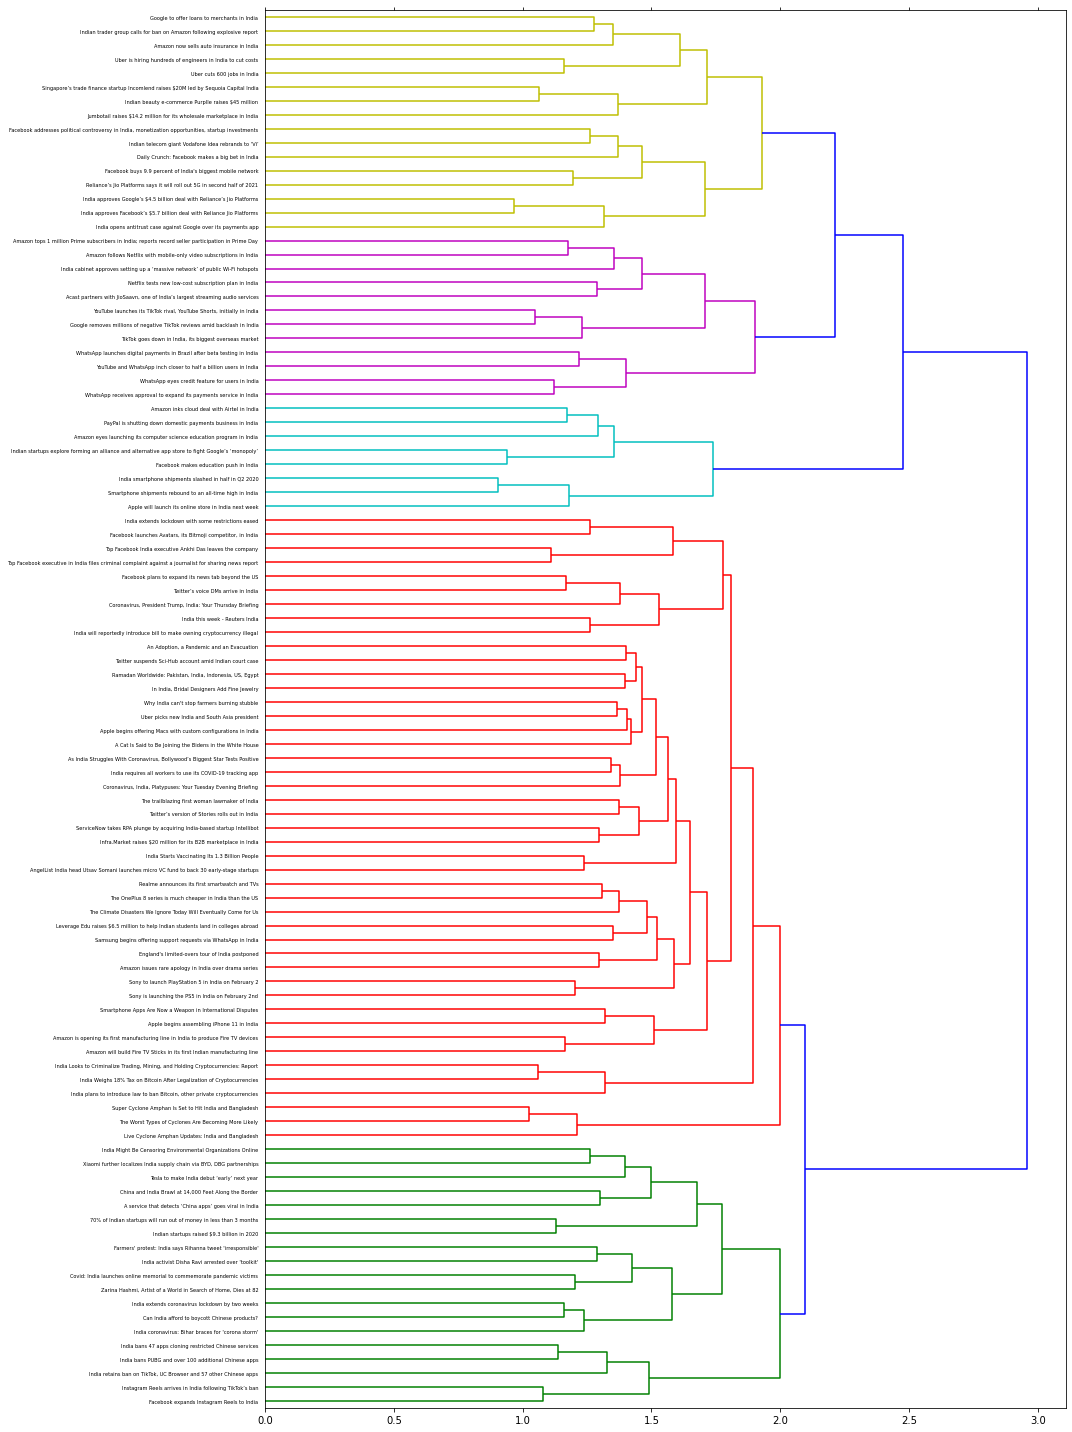

In [27]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [48]:
from scipy.cluster.hierarchy import fcluster

# hand-select an appropriate cut-off on the dendrogram
cluster_labels = fcluster(linkage_matrix, 2, criterion='distance')
print(np.unique(cluster_labels))
cluster_labels = fcluster(linkage_matrix, 2.5, criterion='distance')
print(np.unique(cluster_labels))

[1 2 3 4 5]
[1 2]
